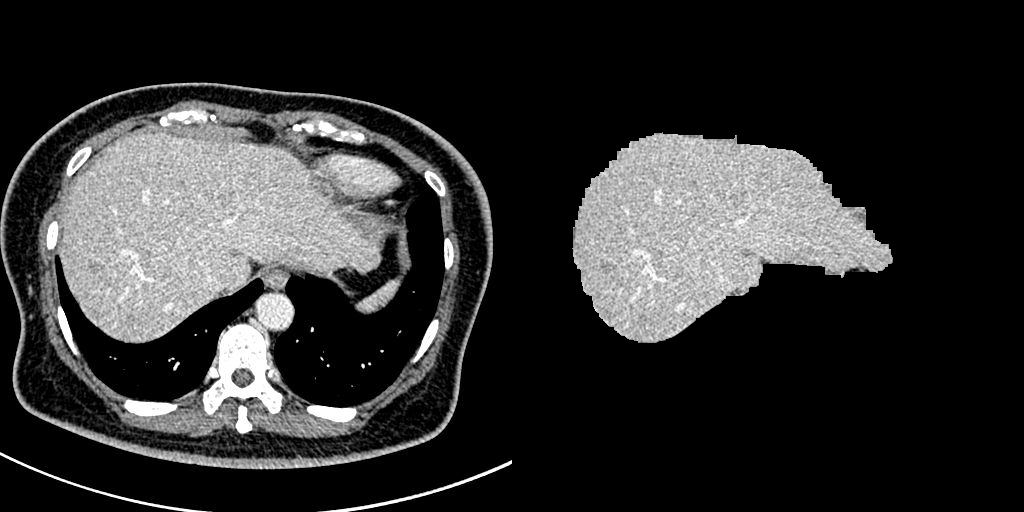

In [52]:
import cv2
import requests
import numpy as np
from PIL import Image
from io import BytesIO
from google.colab.patches import cv2_imshow
from skimage import measure,morphology,img_as_ubyte
import warnings
warnings.simplefilter("ignore")

def BinaryImage(image,value):
  ret,image = cv2.threshold(image,value,255,cv2.THRESH_BINARY)
  return image

def ClearBone(oriImage,binImage):
  resImage = oriImage.copy()
  resImage[binImage != 0] = 0
  return resImage

def CloseImage(image,value):
  kernel = np.ones((value,value),np.uint8)
  return cv2.morphologyEx(image,cv2.MORPH_CLOSE,kernel)

def ConnectImage(image):
  labels = measure.label(image,connectivity=2)
  regions = measure.regionprops(labels)
  region = [region['area'] for region in regions]
  morphology.remove_small_objects(labels, min_size=max(region), connectivity=2, in_place=True)
  return img_as_ubyte(labels)

def DilateImage(image,value):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(value,value))
  return cv2.dilate(image,kernel)

def KeepLiver(oriImage,binImage):
  resImage = oriImage.copy()
  resImage[binImage == 0] = 0
  return resImage

def MedianBlurImage(image,value):
  return cv2.medianBlur(image,value)

def OtsuImage(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  ret,image = cv2.threshold(image,0,255,cv2.THRESH_OTSU)
  return image

if __name__ == "__main__":
  #Load Image
  imageURL = "https://github.com/JasonChennn/Applied-to-Liver-Segmentation-in-Image-Processing/blob/main/demo/test.jpg?raw=true"
  response = requests.get(imageURL)
  oriImage = Image.open(BytesIO(response.content))
  oriImage = np.array(oriImage)[:,:,::-1].copy()

  #Image Processing
  resImage = MedianBlurImage(oriImage,5)
  resImage = BinaryImage(resImage,210)
  resImage = DilateImage(resImage,5)
  resImage = ClearBone(oriImage,resImage)
  resImage = BinaryImage(resImage,178)
  resImage = CloseImage(resImage,3)
  resImage = ConnectImage(resImage)
  resImage = OtsuImage(resImage)
  resImage = CloseImage(resImage,30)
  resImage = KeepLiver(oriImage,resImage)

  #Show Result
  merged_img = cv2.hconcat([oriImage, resImage])
  cv2_imshow(merged_img)
